In [1]:
# what is the variational?

In [2]:
%pylab inline
import os
import time
import random
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = [x/255.0 for x in [x_train, x_test]]
y_train, y_test = [tf.keras.utils.to_categorical(x) for x in [y_train, y_test]]

Populating the interactive namespace from numpy and matplotlib


In [3]:
ZDIM = 4

def get_encoder():
  x = in1 = Input((28,28))
  x = Reshape((28,28,1))(x)

  x = Conv2D(64, (5,5), padding='same', strides=(2,2))(x)
  x = BatchNormalization()(x)
  x = ELU()(x)

  x = Conv2D(128, (5,5), padding='same', strides=(2,2))(x)
  x = BatchNormalization()(x)
  x = ELU()(x)

  x = Flatten()(x)
  x = Dense(ZDIM)(x)
  return Model(in1, x)

def get_decoder():
  x = in1 = Input((ZDIM,))

  x = Dense(7*7*64)(x)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Reshape((7,7,64))(x)

  x = Conv2DTranspose(128, (5,5), strides=(2,2), padding='same')(x)
  x = BatchNormalization()(x)
  x = ELU()(x)

  x = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same')(x)
  x = Activation('sigmoid')(x)
  x = Reshape((28,28))(x)
  return Model(in1, x)

In [4]:
# normal autoencoder without the variational
enc = get_encoder()
ae = Model(enc.input, get_decoder()(enc.output))
ae.compile('adam', 'mse')
ae.summary()
ae.fit(x_train, x_train, batch_size=128, epochs=10, shuffle=1, validation_data=(x_test, x_test))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
elu (ELU)                    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512 

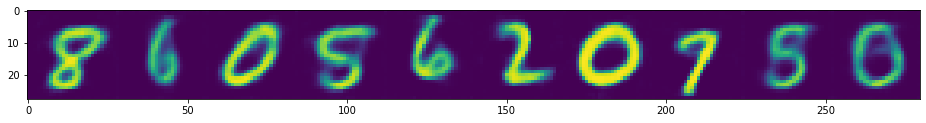

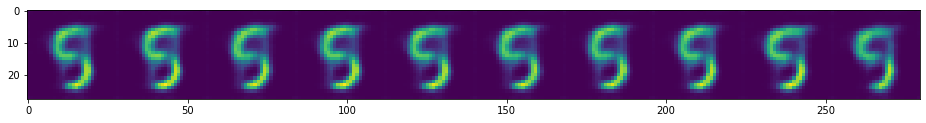

In [5]:
# while the autoencoder might work without the variational, the sampling doesn't
figsize(16,16)
imshow(np.concatenate(ae.predict(np.array([random.choice(x_test) for i in range(10)])), axis=1))
figure()
imshow(np.concatenate(ae.layers[-1].predict(np.random.normal(size=(10, ZDIM))), axis=1))

In [6]:
in1 = Input((28,28))
x = get_encoder()(in1)

# add the variational
z_mu = Dense(ZDIM)(x)
z_log_var = Dense(ZDIM)(x)
z = Lambda(lambda x: x[0] + K.exp(0.5 * x[1]) * K.random_normal(shape=K.shape(x[0])))([z_mu, z_log_var])
out = get_decoder()(z)

mse_loss = mse(Reshape((28*28,))(in1), Reshape((28*28,))(out)) * 28 * 28
kl_loss = 1 + z_log_var - K.square(z_mu) - K.exp(z_log_var)
kl_loss = -0.5 * K.mean(kl_loss, axis=-1)

vae = Model(in1, out)
vae.add_loss(K.mean(mse_loss + kl_loss))
vae.compile('adam')

In [7]:
# z is sampled from z_mu and z_log_var with gaussian noise
test = Model(in1, [z, z_mu, z_log_var])
test.predict(x_train[0:1])

[array([[-0.36135393,  1.8782282 , -2.056991  , -0.60052466]],
       dtype=float32),
 array([[ 0.01278172,  0.00325583, -0.00295223,  0.02152798]],
       dtype=float32),
 array([[ 0.01860134, -0.03426083, -0.00210588, -0.04922588]],
       dtype=float32)]

In [8]:
vae.fit(x_train, batch_size=128, epochs=10, shuffle=1, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 172us/sample - loss: 106.9424 - val_loss: 49.5300
Epoch 2/10
60000/60000 [==============================] - 7s 123us/sample - loss: 40.6906 - val_loss: 38.4624
Epoch 3/10
60000/60000 [==============================] - 8s 126us/sample - loss: 37.5029 - val_loss: 36.0076
Epoch 4/10
60000/60000 [==============================] - 7s 123us/sample - loss: 35.5239 - val_loss: 34.0764
Epoch 5/10
60000/60000 [==============================] - 7s 124us/sample - loss: 34.0624 - val_loss: 32.7335
Epoch 6/10
60000/60000 [==============================] - 8s 125us/sample - loss: 33.0450 - val_loss: 32.2324
Epoch 7/10
60000/60000 [==============================] - 7s 123us/sample - loss: 32.2560 - val_loss: 31.2762
Epoch 8/10
60000/60000 [==============================] - 7s 123us/sample - loss: 31.7095 - val_loss: 30.9809
Epoch 9/10
60000/60000 [==============================] - 7s 125us/s

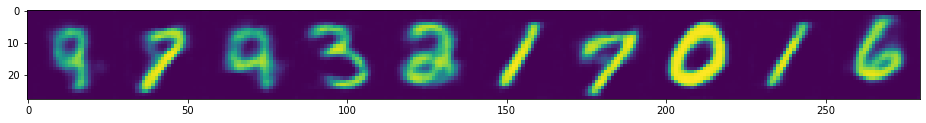

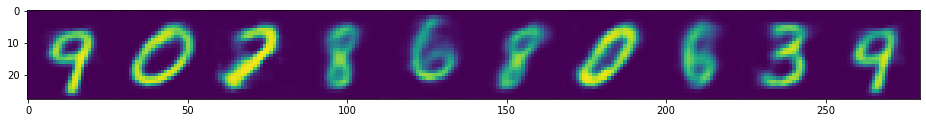

In [9]:
figsize(16,16)
imshow(np.concatenate(vae.predict(np.array([random.choice(x_test) for i in range(10)])), axis=1))
figure()
imshow(np.concatenate(vae.layers[5].predict(np.random.normal(size=(10, ZDIM))), axis=1))